In [1]:
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from libpysal.graph import read_parquet
from sklearn.preprocessing import PowerTransformer, RobustScaler, StandardScaler

In [2]:
from core.cluster_validation import generate_neigbhourhood_groups, colored_crosstab
from core.utils import used_keys

In [3]:
import umap
import umap.plot
from palettable.colorbrewer.qualitative import Set3_12
from sklearn.metrics import davies_bouldin_score

/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/krasen/miniconda3/envs/urban_taxonomy/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than

In [4]:
region_id = 69300

tessellations_dir = '/data/uscuni-ulce/processed_data/tessellations/'
chars_dir = "/data/uscuni-ulce/processed_data/chars/"
graph_dir = "/data/uscuni-ulce/processed_data/neigh_graphs/"

In [5]:
# region_id = 4182

# tessellations_dir = graph_dir = '../data/ms_buildings/'
# chars_dir = '../data/ms_buildings/chars/'

In [ ]:
spatial_lag = 1


X_train = pd.read_parquet(chars_dir + f'primary_chars_{region_id}.parquet')

# lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/context_chars_{region_id}_lag_{spatial_lag}.parquet')

lag = pd.read_parquet(f'/data/uscuni-ulce/processed_data/context_data/unprocessed_context_chars_{region_id}_lag_{spatial_lag}.parquet')


# X_train = X_train.join(lag[[c for c in lag.columns if '_median' in c]], how='inner')

# X_train = X_train.join(lag, how='inner')

X_train.shape

In [ ]:
X_train = X_train[X_train.index >= 0]


vals = np.nan_to_num(StandardScaler().fit_transform(X_train))
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)
# X_train = X_train.clip(-10, 10)

vals = np.nan_to_num(X_train)
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)

In [ ]:
# tessellation = gpd.read_parquet(
#         tessellations_dir + f"tessellation_{region_id}.parquet"
# )
# tessellation = tessellation[tessellation.index.isin(X_train.index)]

In [6]:
X_train = pd.read_parquet('../data/old_prague_data/old_prague_data.parquet')
X_train = X_train.set_index('uID').sort_index()
tessellation = gpd.read_file('../data/old_prague_data/prg_geometry.gpkg', 
                             layer='tessellation').set_index('uID').sort_index().to_crs(epsg=3035)

vals = np.nan_to_num(StandardScaler().fit_transform(X_train))
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)
# X_train = X_train.clip(-10, 10)

vals = np.nan_to_num(X_train)
X_train = pd.DataFrame(vals, columns=X_train.columns, index=X_train.index)

In [7]:
tess_groups = generate_neigbhourhood_groups(tessellation, 
                                         include_random_sample=True,
                                         random_sample_size=1_000)
tess_groups = tess_groups[tess_groups.index.isin(X_train.index)]
tess_groups_ilocs = (
    pd.Series(np.arange(len(X_train)), index=X_train.index)
    .loc[tess_groups.index]
    .values
)

def check_score(data, example_clusters):
    groups = example_clusters[example_clusters.index.isin(data.index)]
    groups_ilocs = (
        pd.Series(np.arange(len(data)), index=data.index).loc[groups.index].values
    )
    return davies_bouldin_score(data.iloc[groups_ilocs], groups.values)

In [8]:
# tessellation.loc[tess_groups.index].explore()

In [9]:
from core.cluster_validation import print_distance
print_distance( pd.DataFrame(X_train.loc[tess_groups.index]).groupby(tess_groups.values).median(), metric='sqeuclidean')

,holyne,housing estate,josefov,karlin,mala strana,malesice,nusle,random,stare mesto,vinohrady
holyne,0.000000,163.525113,559.021522,388.325319,872.690339,1377.462677,228.300469,90.187665,766.408014,464.154566
housing estate,163.525113,0.000000,311.086171,245.426710,681.908455,1352.213852,69.026138,44.126368,524.150801,273.204811
josefov,559.021522,311.086171,0.000000,263.505035,520.408932,1896.130594,181.672464,354.679883,171.753231,159.625003
karlin,388.325319,245.426710,263.505035,0.000000,533.945743,1276.825983,208.860738,255.762992,350.642954,171.274089
mala strana,872.690339,681.908455,520.408932,533.945743,0.000000,1865.409288,608.201652,724.551057,249.134824,795.619021
malesice,1377.462677,1352.213852,1896.130594,1276.825983,1865.409288,0.000000,1495.787728,1374.697149,1939.989904,1786.280630
nusle,228.300469,69.026138,181.672464,208.860738,608.201652,1495.787728,0.000000,75.390239,394.789873,190.528438
random,90.187665,44.126368,354.679883,255.762992,724.551057,1374.697149,75.390239,0.000000,565.221601,271.102284
stare mesto,766.408014,524.150801,171.753231,350.642954,249.134824,1939.989904,394.789873,565.221601,0.000000,387.901388
vinohrady,464.154566,273.204811,159.625003,171.274089,795.619021,1786.280630,190.528438,271.102284,387.901388,0.000000


In [10]:
def show_nn(n_neighbors, n_components, n_epochs, min_dist):
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        n_epochs=n_epochs,
    )
    embedding = reducer.fit_transform(X_train.iloc[tess_groups_ilocs])

    embedding_df = pd.DataFrame(embedding, index=tess_groups.index)
    embedding_df["neighbourhood"] = tess_groups.values

    print(
        n_neighbors,
        n_components,
        n_epochs,
        min_dist,
        "--",
        davies_bouldin_score(embedding, tess_groups.values),
    )

    if n_components == 2:
        return umap.plot.points(reducer, labels=tess_groups.values)
    else:
        return None

15 2 100 0.0 -- 1.8047301147409094
25 2 100 0.0 -- 1.307972736916297
50 2 100 0.0 -- 2.2944860140222145
100 2 100 0.0 -- 1.315726137876355


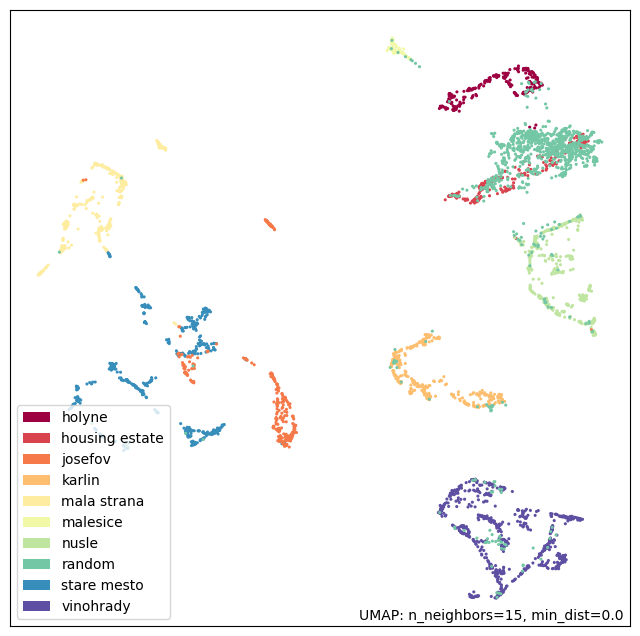

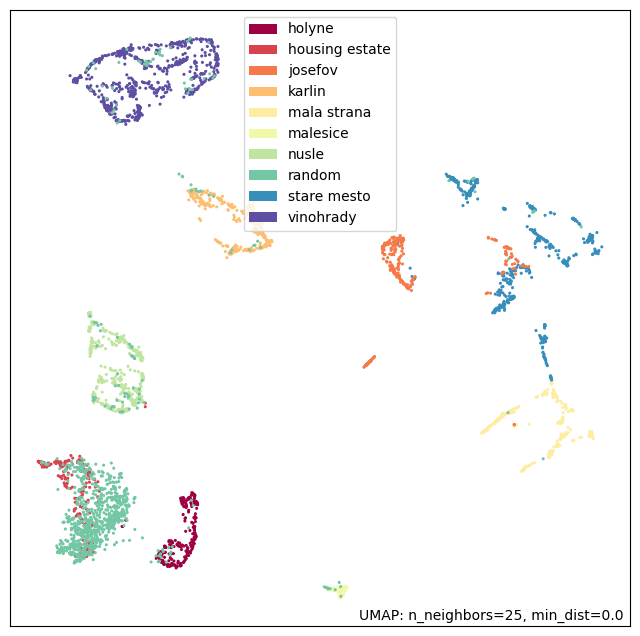

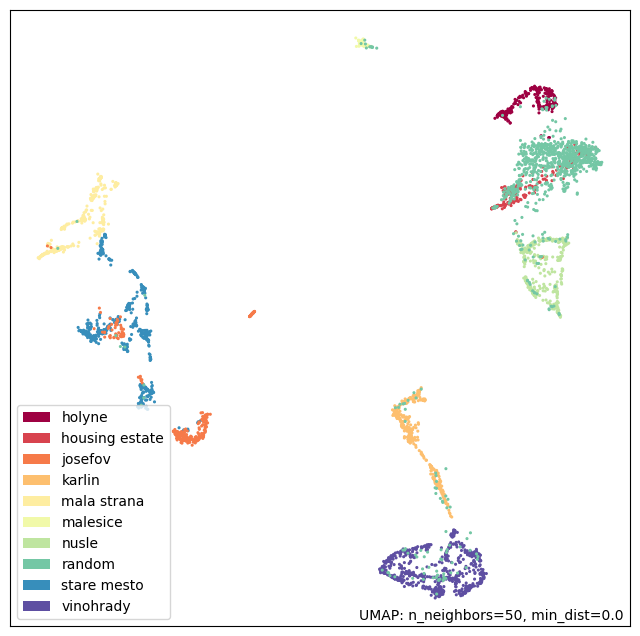

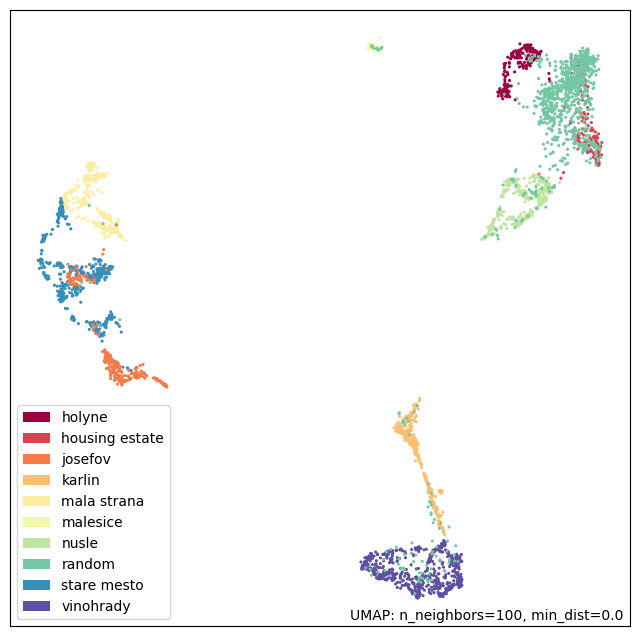

In [11]:
for n_neighbors in [15, 25, 50, 100]:
    show_nn(n_neighbors=n_neighbors, n_components=2, n_epochs=100, min_dist=0.0)

In [12]:
data = X_train.values

In [14]:
n_neighbors = 25
negative_sample_rate = n_neighbors
n_epochs = 5000

noise_level = .5
learning_rate = 1

neighbor_scale = 1.0
symmetrize_graph = True
node_embedding_dim = 2

In [15]:
### need to compute knn + 1, and then pass the results[1:], there is an issue with the evoc functions - numerical maybe
### the nndescent approximation gets the relative density of the nearest neighbours correct compared to real distances
### should try to initialise this graph somehow differently based on contiguity - immidiate spatial neighbours are 1s, other neighbours are based on knn similarity

In [16]:
from evoc.knn_graph import knn_graph
from evoc.graph_construction import neighbor_graph_matrix, smooth_knn_dist, compute_membership_strengths

/home/krasen/evoc/evoc/float_nndescent.py:287: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  points = point_indices[i]


In [17]:
%%time
nn_inds, nn_dists = knn_graph(data, n_neighbors=n_neighbors+1)

CPU times: user 38.3 s, sys: 441 ms, total: 38.8 s
Wall time: 3.44 s


In [18]:
%%time

graph = neighbor_graph_matrix(
    neighbor_scale * n_neighbors, nn_inds[:, 1:], nn_dists[:, 1:], symmetrize_graph
)

CPU times: user 857 ms, sys: 7.61 ms, total: 864 ms
Wall time: 333 ms


In [19]:
from evoc.label_propagation import label_propagation_init

In [20]:
%%time
init_embedding = label_propagation_init(
            graph,
            n_components=node_embedding_dim,
            approx_n_parts=np.clip(int(np.sqrt(data.shape[0])), 100, 1024),
            random_scale=0.1,
            scaling=0.5,
            noise_level=noise_level,
        )

CPU times: user 4.74 s, sys: 0 ns, total: 4.74 s
Wall time: 342 ms


In [21]:
from evoc.node_embedding import node_embedding

In [22]:
graph = graph.tocoo()

In [23]:
%%time
embedding = node_embedding(
        graph,
        n_components=node_embedding_dim,
        n_epochs=n_epochs,
        initial_embedding=init_embedding,
        negative_sample_rate=negative_sample_rate,
        noise_level=noise_level,
        verbose=True,
    )

/home/krasen/evoc/evoc/node_embedding.py:13: RuntimeWarning: overflow encountered in divide
  result[n_samples > 0] = float(n_epochs) / np.float32(n_samples[n_samples > 0])


CPU times: user 2min 56s, sys: 478 ms, total: 2min 56s
Wall time: 10.5 s


In [24]:
def plot_datashade_umap(embedding, labels=None, n_neighbors=0.0, min_dist=0.0):
    class MockEmbedding(object):
        pass
    
    enb = MockEmbedding()
    enb.embedding = embedding
    enb.n_neighbors = n_neighbors
    enb.min_dist = 0.0

    if labels is None:
        return umap.plot.points(enb)
    
    return umap.plot.points(enb, labels=labels)

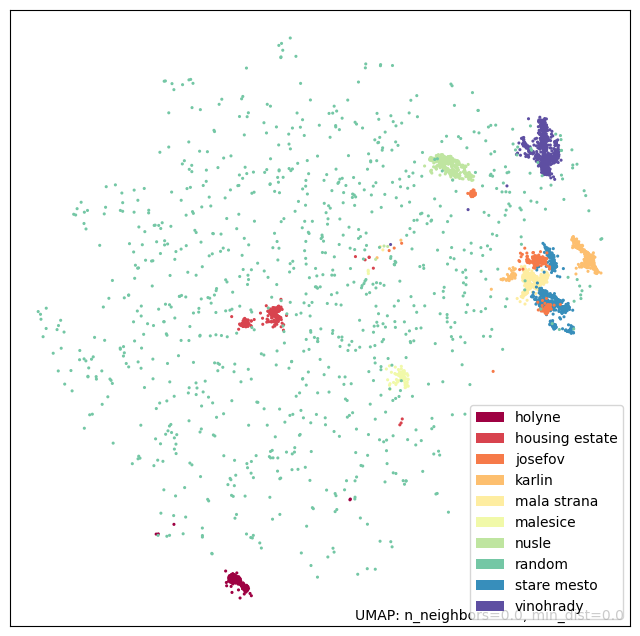

In [25]:
if node_embedding_dim == 2:
    plot_datashade_umap(embedding[tess_groups_ilocs], tess_groups.values)

In [26]:
davies_bouldin_score(
    embedding[tess_groups_ilocs], 
    tess_groups.values
)

np.float64(1.6924131609511792)

In [ ]:
# x, y = tessellation.loc[tess_groups.index].representative_point().x.values, tessellation.loc[tess_groups.index].representative_point().y.values

In [27]:
rps = tessellation[tessellation.index.isin(X_train.index)].representative_point()
x, y = rps.x.values, rps.y.values

In [28]:
spatial_init = np.vstack((x,y)).T
spatial_init = StandardScaler().fit_transform(spatial_init)
spatial_init = np.ascontiguousarray(spatial_init, dtype=np.float32)

<Axes: >

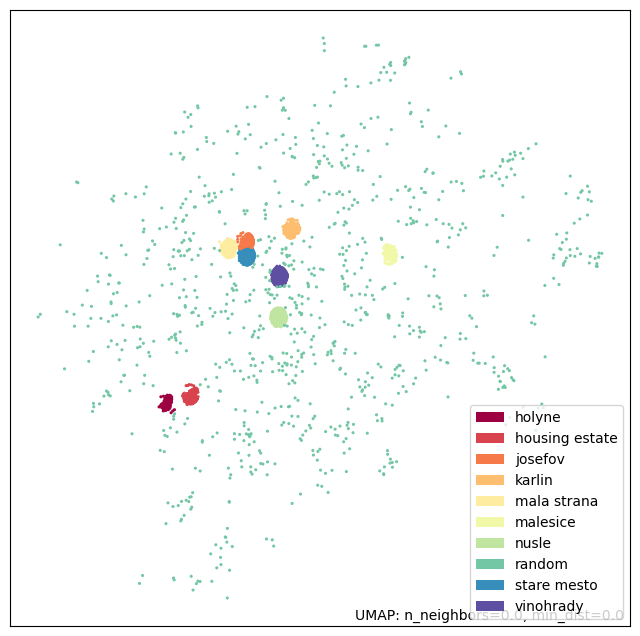

In [29]:
plot_datashade_umap(spatial_init[tess_groups_ilocs], tess_groups.values)

In [30]:
# negative_sample_rate = 50
# noise_level = .01
# n_epochs = 10000

In [31]:
new_spatial_init = spatial_init
new_node_embedding_dim = node_embedding_dim

In [32]:
# new_node_embedding_dim = 5
# new_spatial_init = np.ascontiguousarray(np.hstack((spatial_init,
#                                                    np.random.randn(spatial_init.shape[0], new_node_embedding_dim - 2))), 
#                                         dtype=np.float32)
# new_spatial_init

In [33]:
# new_node_embedding_dim = spatial_init.shape[1] + init_embedding.shape[1]
# new_spatial_init = np.ascontiguousarray(np.hstack((spatial_init, init_embedding)), 
#                                         dtype=np.float32)
# new_spatial_init

In [34]:
%%time
spatial_embedding = node_embedding(
        graph,
        n_components=new_node_embedding_dim,
        n_epochs=n_epochs,
        initial_embedding=new_spatial_init,
        negative_sample_rate=negative_sample_rate,
        noise_level=noise_level,
        initial_alpha=learning_rate,
        verbose=False,
    )

/home/krasen/evoc/evoc/node_embedding.py:13: RuntimeWarning: overflow encountered in divide
  result[n_samples > 0] = float(n_epochs) / np.float32(n_samples[n_samples > 0])


CPU times: user 2min 56s, sys: 619 ms, total: 2min 57s
Wall time: 10.5 s


In [35]:
spatial_embedding

array([[-10.891737 ,  -8.532346 ],
       [-28.32341  ,   7.5458603],
       [ 26.701258 ,  -5.089967 ],
       ...,
       [-11.5462885,   3.5332181],
       [-11.26357  ,   6.637029 ],
       [ -2.4256685,   3.6577888]], dtype=float32)

<Axes: >

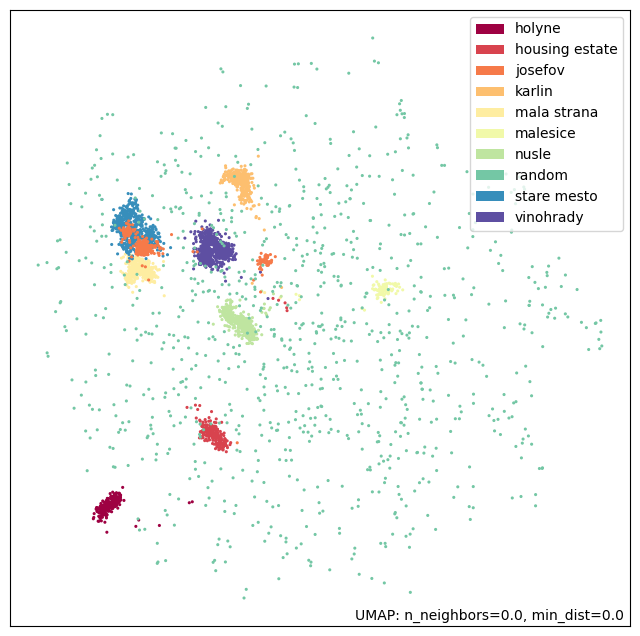

In [36]:
plot_datashade_umap(spatial_embedding[tess_groups_ilocs], tess_groups.values)

<Axes: >

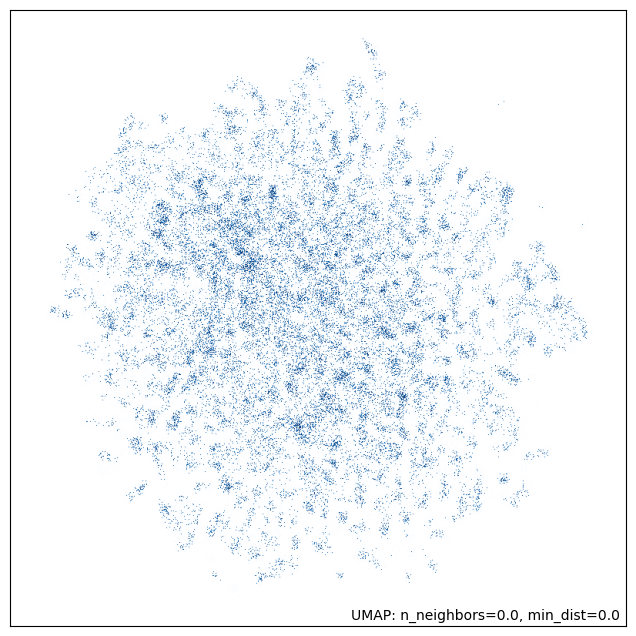

In [37]:
plot_datashade_umap(spatial_embedding)

<Axes: >

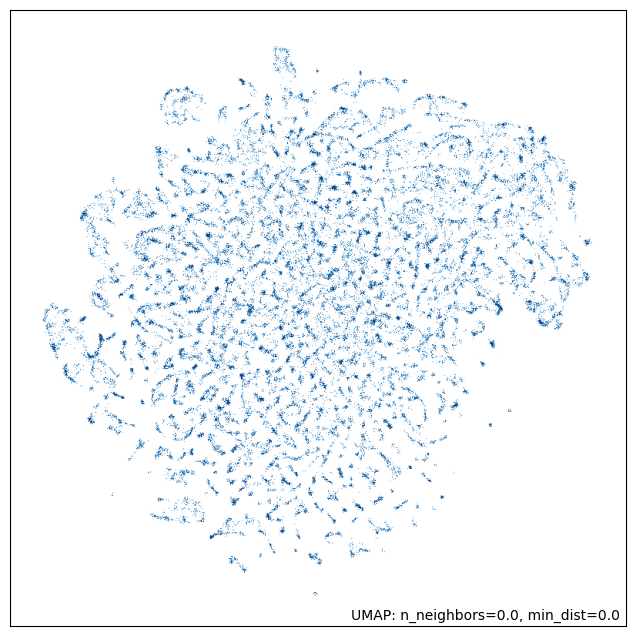

In [38]:
plot_datashade_umap(embedding)

In [41]:
davies_bouldin_score(
    spatial_embedding[tess_groups_ilocs], 
    tess_groups.values
), davies_bouldin_score(
    embedding[tess_groups_ilocs], 
    tess_groups.values
)

(np.float64(1.6171346831119606), np.float64(1.6924131609511792))

In [43]:
print_distance( pd.DataFrame(embedding[tess_groups_ilocs]).groupby(tess_groups.values).median(), metric='sqeuclidean')

,holyne,housing estate,josefov,karlin,mala strana,malesice,nusle,random,stare mesto,vinohrady
holyne,0.000000,1888.066523,5425.233109,6344.761169,4996.874422,1911.555582,5942.393004,2466.916254,4952.982676,7648.307937
housing estate,1888.066523,0.000000,2164.317814,2948.133414,2011.684526,577.487319,1527.738930,63.675652,2261.179807,2868.091399
josefov,5425.233109,2164.317814,0.000000,61.560373,10.584247,915.471611,487.202061,1573.216648,51.214193,308.877396
karlin,6344.761169,2948.133414,61.560373,0.000000,93.119889,1362.886668,778.471301,2256.372471,88.849955,343.503344
mala strana,4996.874422,2011.684526,10.584247,93.119889,0.000000,755.731964,556.652067,1465.887829,24.396180,427.808499
malesice,1911.555582,577.487319,915.471611,1362.886668,755.731964,0.000000,1265.305337,469.212040,795.110716,1925.518220
nusle,5942.393004,1527.738930,487.202061,778.471301,556.652067,1265.305337,0.000000,967.621075,814.074721,268.426795
random,2466.916254,63.675652,1573.216648,2256.372471,1465.887829,469.212040,967.621075,0.000000,1716.892126,2088.935060
stare mesto,4952.982676,2261.179807,51.214193,88.849955,24.396180,795.110716,814.074721,1716.892126,0.000000,599.454438
vinohrady,7648.307937,2868.091399,308.877396,343.503344,427.808499,1925.518220,268.426795,2088.935060,599.454438,0.000000


In [44]:
print_distance( pd.DataFrame(spatial_embedding[tess_groups_ilocs]).groupby(tess_groups.values).median(), metric='sqeuclidean')

,holyne,housing estate,josefov,karlin,mala strana,malesice,nusle,random,stare mesto,vinohrady
holyne,0.000000,457.910001,1902.691604,3506.146598,1591.252420,3545.388144,1449.358926,1937.393085,2127.850859,2136.474288
housing estate,457.910001,0.000000,1132.969963,1857.291164,931.546025,1460.349024,375.743834,531.283437,1364.895185,950.842201
josefov,1902.691604,1132.969963,0.000000,421.960725,13.934844,1785.662839,445.249515,923.562953,11.508654,145.389800
karlin,3506.146598,1857.291164,421.960725,0.000000,541.754153,947.677992,577.328124,737.079737,439.650875,168.760957
mala strana,1591.252420,931.546025,13.934844,541.754153,0.000000,1800.596329,388.119331,870.462775,42.976264,170.645070
malesice,3545.388144,1460.349024,1785.662839,947.677992,1800.596329,0.000000,641.893441,257.898206,2003.450867,919.688772
nusle,1449.358926,375.743834,445.249515,577.328124,388.119331,641.893441,0.000000,104.361225,593.674582,168.966113
random,1937.393085,531.283437,923.562953,737.079737,870.462775,257.898206,104.361225,0.000000,1119.403430,401.581745
stare mesto,2127.850859,1364.895185,11.508654,439.650875,42.976264,2003.450867,593.674582,1119.403430,0.000000,208.348060
vinohrady,2136.474288,950.842201,145.389800,168.760957,170.645070,919.688772,168.966113,401.581745,208.348060,0.000000


In [ ]:
%%time

from evoc.clustering import build_cluster_layers

# input_embedding = embedding
input_embedding = spatial_embedding
min_num_clusters = 4
min_samples = n_neighbors
base_min_cluster_size = min_samples
next_cluster_size_quantile = .8

cluster_layers, membership_strengths = build_cluster_layers(
            input_embedding,
            min_clusters=min_num_clusters,
            min_samples=min_samples,
            base_min_cluster_size=base_min_cluster_size,
            next_cluster_size_quantile=next_cluster_size_quantile,
)

In [ ]:
n_points_clustered_per_layer = [
    # np.sum(layer >= 0) for layer in cluster_layers
    np.mean(layer_strengths[layer_clusters >= 0]) for layer_clusters, layer_strengths in zip(cluster_layers, membership_strengths)
]
best_layer = np.argmax(n_points_clustered_per_layer)
best_layer

In [ ]:
n_points_clustered_per_layer

In [ ]:
# %%time

# from core.generate_streets import record_batch_reader

# region_name = 69300
# regions_datadir = "/data/uscuni-ulce/"
# region_hulls = gpd.read_parquet(
#         regions_datadir + "regions/" + "regions_hull.parquet"
#     )
# region_id, region_hull = region_hulls.loc[region_name].name, region_hulls.to_crs(epsg=4326).loc[region_name].convex_hull

# batches = record_batch_reader('division_area', bbox=region_hull.bounds).read_all()
# gdf = gpd.GeoDataFrame.from_arrow(batches)
# gdf = gdf.iloc[gdf.sindex.query(region_hull, predicate='intersects')]

# prague_neighbourhoods = gdf[gdf['subtype'] == 'locality'].set_crs(epsg=4326)
# prague_neighbourhoods['names'] = prague_neighbourhoods['names'].apply(lambda x: x['primary'])
# prague_neighbourhoods = prague_neighbourhoods[['geometry', 'names']].to_crs(epsg=3035)
# prague_neighbourhoods.to_parquet('../data/prague_neighbourhoods.parquet')

In [ ]:
# import bokeh
# prague_neighbourhoods = gpd.read_parquet('../data/prague_neighbourhoods.parquet')

In [ ]:
# umap.plot.output_notebook()


In [ ]:
# plotting = tessellation.copy()
# plotting = plotting[plotting.index.isin(X_train.index)]
# inp, res = plotting.representative_point().sindex.query(prague_neighbourhoods.geometry, predicate='intersects')

In [ ]:
# class MockEmbedding(object):
#     pass

# enb = MockEmbedding()
# enb.embedding = spatial_embedding[res]
# enb.n_neighbors = n_neighbors
# enb.min_dist = 0.0

In [ ]:
# hover_data = X_train.iloc[res, :2]
# hover_data['label'] = prague_neighbourhoods.iloc[inp, 1].values

In [ ]:
# p = umap.plot.interactive(enb, hover_data=hover_data, point_size=2)
# umap.plot.show(p)

In [ ]:
from fast_hdbscan.boruvka import parallel_boruvka
from fast_hdbscan.cluster_trees import (
    cluster_tree_from_condensed_tree,
    condense_tree,
    extract_eom_clusters,
    get_cluster_label_vector,
    mst_to_linkage_tree,
)
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from sklearn.neighbors import KDTree

In [ ]:

min_cluster_size = n_neighbors

In [ ]:
%%time
# sklearn_tree = KDTree(embedding)

sklearn_tree = KDTree(spatial_embedding)

numba_tree = kdtree_to_numba(sklearn_tree)
edges = parallel_boruvka(numba_tree, min_samples=min_cluster_size)
sorted_mst = edges[np.argsort(edges.T[2])]
linkage_tree = mst_to_linkage_tree(sorted_mst)
condensed_tree = condense_tree(linkage_tree, min_cluster_size=300)
cluster_tree = cluster_tree_from_condensed_tree(condensed_tree)
selected_clusters = extract_eom_clusters(
    condensed_tree, cluster_tree, allow_single_cluster=False
)
clusters = get_cluster_label_vector(condensed_tree, selected_clusters, 0)

In [ ]:
np.unique(clusters, return_counts=True)

In [ ]:
from lonboard import PolygonLayer, Map
from lonboard.basemap import CartoBasemap
from lonboard.colormap import apply_categorical_cmap
from palettable.colorbrewer.qualitative import Set3_12

In [ ]:
plotting = tessellation.loc[X_train.index].copy().reset_index()

In [ ]:
if 'uID' in plotting.columns:
    plotting['index'] = 'uID'

In [ ]:
from core.cluster_validation import get_color

In [ ]:
layer = PolygonLayer.from_geopandas(
    gdf=plotting[["geometry", 'index']], opacity=0.15
)

In [ ]:
# m = Map(layer, basemap_style=CartoBasemap.Positron)
# m

In [ ]:
clusters = cluster_layers[5]

In [ ]:
np.unique(clusters, return_counts=True)

In [ ]:
layer.get_fill_color = get_color(clusters)

In [ ]:
pd.Series(membership_strengths[4]).describe()

In [ ]:
plot_datashade_umap(spatial_embedding, labels=cluster_layers[5])

In [ ]:
from core.cluster_validation import colored_crosstab

In [ ]:
colored_crosstab(clusters[tess_groups_ilocs], tess_groups.values)

----

#### Graph construction

In [ ]:
# %%time
from fast_hdbscan.numba_kdtree import kdtree_to_numba
from fast_hdbscan.numba_kdtree import parallel_tree_query

graph = read_parquet(graph_dir + f"tessellation_graph_{region_id}_knn1.parquet")

from sklearn.neighbors import KDTree

sklearn_tree = KDTree(data)
numba_tree = kdtree_to_numba(sklearn_tree)
# result = parallel_tree_query(numba_tree, np.ascontiguousarray(data), k=n_neighbors)

# nn_dists, nn_inds = result

In [ ]:
# app_nn_inds, app_nn_dists = knn_graph(data, n_neighbors=n_neighbors)

In [ ]:
sigmas, rhos = smooth_knn_dist(
        nn_dists[:, 1:],
        float(n_neighbors),
    )

In [ ]:
np.allclose(rhos, nn_dists[:, 1])

In [ ]:
%%time


actual_dists, actual_knns = parallel_tree_query(numba_tree, np.ascontiguousarray(data[:5, :]), k=n_neighbors+1)

In [ ]:
actual_sigmas, actual_rhos = smooth_knn_dist(
        actual_dists[:, 1:],
        float(n_neighbors),
)

In [ ]:
actual_dists[:, 1], rhos[:5]

In [ ]:
sigmas[:5], actual_sigmas

In [ ]:
actual_knns[0], nn_inds[0]

In [ ]:
from scipy.spatial.distance import cdist

In [ ]:
np.allclose(cdist(X_train.iloc[[actual_knns[0, 0]]], X_train.iloc[actual_knns[0, 1:]])[0], actual_dists[0][1:])

In [ ]:
cdist(X_train.iloc[[nn_inds[0, 0]]], X_train.iloc[nn_inds[0, 1:]])[0], actual_dists[0][1:]

In [ ]:
rows, cols, vals = compute_membership_strengths(
        np.ascontiguousarray(nn_inds[:, 1:]), np.ascontiguousarray(nn_dists[:, 1:]), sigmas, rhos
)

In [ ]:
vals[:25]

In [ ]:
vs = compute_membership_strengths(
        np.ascontiguousarray(actual_knns[:, 1:]), np.ascontiguousarray(actual_dists[:, 1:]), actual_sigmas, actual_rhos
)[2]
vs[:25]

In [ ]:
smooth_knn_dist(
        nn_dists[:, 1:],
        float(n_neighbors),
    )

In [ ]:
# # r = pd.read_csv('https://figshare.com/ndownloader/files/31252825', compression='gzip')
# import requests 
# r = pd.read_csv('https://figshare.com/ndownloader/files/31250227', compression='gzip')
# r = r.drop([ 'mm_len', 'cdsbool', 'node_start', 'node_end', 'nID', 'nodeID', 'Unnamed: 0', 'bID',], axis=1).set_index('uID').sort_index()
# X_train.join(r).reset_index().to_parquet('../data/old_prague_data/old_prague_data.parquet')



# def download_url(url, save_path, chunk_size=128):
#     r = requests.get(url, stream=True)
#     with open(save_path, 'wb') as fd:
#         for chunk in r.iter_content(chunk_size=chunk_size):
#             fd.write(chunk)
# download_url('https://figshare.com/ndownloader/files/31252828', '../data/old_prague_geometries.zip') 
# import zipfile
# z = zipfile.ZipFile('../data/old_prague_geometries.zip')
# z.extractall("../data/old_prague_geometries/")

